In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from copy import deepcopy

import scipy
from scipy import special as s
import pandas as pd
import numpy
import math
from time import time

/Users/karlhajjar/Documents/projects/deep-wide-resnets/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks.muP_resnet import MuPResNet

# Constants

In [6]:
INPUT_DIM = 64 #30
WIDTH = 256 #512 #512 # 512 #40 # 256
#D_MODEL = 128
N_RES = 1000 # 1000 #1000
BIAS = False
ALPHA = 1.0
SCALE = 1.0
ACTIVATION = 'relu'

SEED = 42
N_SAMPLES = 50 #100
N_TRIALS = 10
BASE_LR = 1.0e-4

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/init/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

# Glorot init

In [9]:
(start, num) = (10, 10)
betas = [0.25, 0.5, 1.0] #[0., 0.25, 0.5, 1.0]
all_x = torch.randn(size=(N_TRIALS, N_SAMPLES, INPUT_DIM))
n_res_grid = np.linspace(start=start, stop=N_RES, num=num, dtype=int)

ratios = dict()
th_ratios = dict()
s = time()
with torch.no_grad():
    for beta in betas:
        ratios_ = {n_res: [] for n_res in n_res_grid}
        th_ratios_ = {n_res: [] for n_res in n_res_grid}
        for n_res in n_res_grid:
            for i in range(N_TRIALS):
                alpha = n_res**(-beta)
                net = MuPResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, 
                                n_res=n_res)
                x = all_x[i, :, :]

                h_0 = net.input_layer(x)
                h_L = net.residual_layers(h_0)
                
                h_0_norm = torch.norm(h_0, dim=1, p=2)
                factor = np.sqrt((1 + alpha**2)**(n_res) - 1)

                ratios_[n_res].append(torch.mean((torch.norm(h_L-h_0, dim=1,p=2)) /
                                                  h_0_norm).detach().item())
                
                ratios_[n_res].append(factor)

        ratios[beta] = ratios_
        th_ratios[beta] = th_ratios_
        
e = time()
print('Time for L={:,} and N_TRIALS={:,} : {:.2f} minutes'.format(N_RES, N_TRIALS, (e - s)/60))

Time for L=1,000 and N_TRIALS=10 : 7.20 minutes


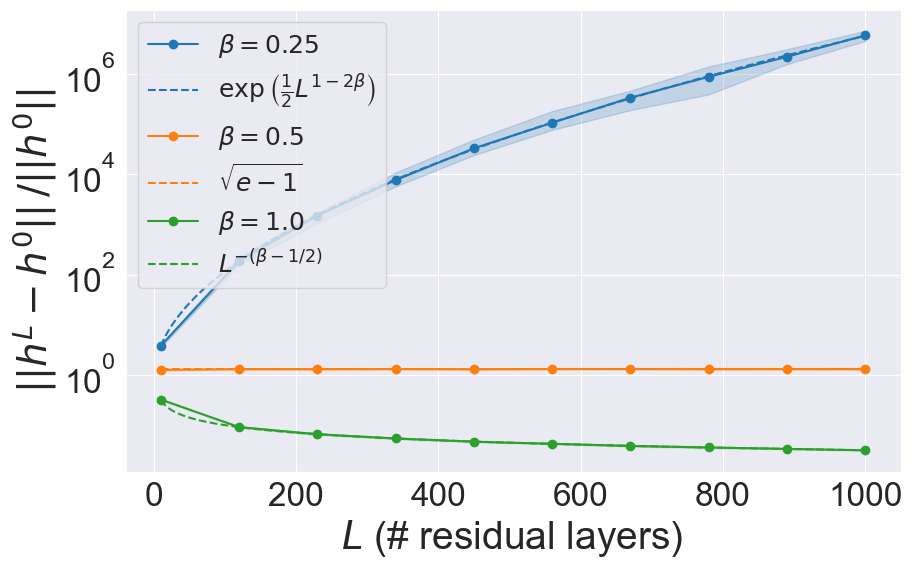

In [10]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
#plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(ratios.keys()):
    data = pd.DataFrame(ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.arange(start, N_RES+1)  ** (delta/2), 
                 label='$L^{-(\\beta - 1/2)}$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), len(np.arange(start, N_RES+1)) * [np.sqrt(np.exp(1) - 1)], 
                 label='$\\sqrt{e - 1}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L - h^0|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

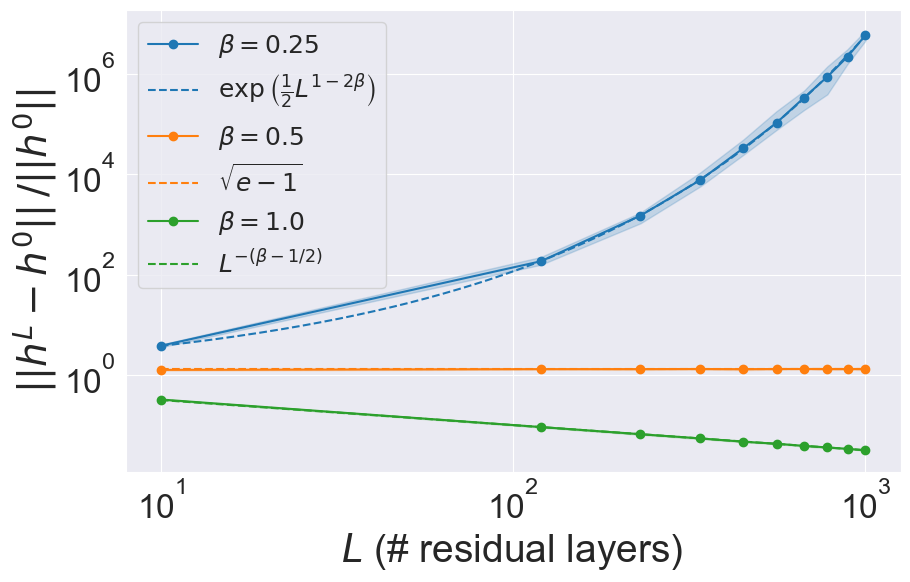

In [11]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = 'o'
plt.xscale('log')
colors = sns.color_palette()

for i, key in enumerate(ratios.keys()):
    data = pd.DataFrame(ratios[key])
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values
    
    delta = 1 - 2 * key

    plt.plot(data.columns.values, means, marker=marker, label='$\\beta = {}$'.format(key), c=colors[i])
    plt.fill_between(data.columns.values, mins, maxs, alpha=0.2, color=colors[i])

    if delta > 0:
        plt.plot(np.arange(start, N_RES+1), np.exp(((np.arange(start, N_RES+1) ** delta) -0.5)/2), 
                 label='$\\exp \\left(\\frac{1}{2} L^{1 -2\\beta} \\right)$', c=colors[i], linestyle='dashed')
    elif delta < 0:
        plt.plot(np.arange(start, N_RES+1), np.arange(start, N_RES+1)  ** (delta/2), 
                 label='$L^{-(\\beta - 1/2)}$', c=colors[i], linestyle='dashed')
    else:  # delta = 0
        plt.plot(np.arange(start, N_RES+1), len(np.arange(start, N_RES+1)) * [np.sqrt(np.exp(1) - 1)], 
                 label='$\\sqrt{e - 1}$', c=colors[i], linestyle='dashed')

plt.xlabel('$L$ (# residual layers) ', fontsize=28)
plt.ylabel('$||h^L - h^0|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'ratio_log-log.png'), bbox_inches='tight')
plt.show()